In [1]:
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd

sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/')
sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/utils')
sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/models')

from utils.analysis import *
from utils.getters import * 
from utils.plotters import * 
from utils.helpers import * 
from models.model_config import *


## Reproducibility

In [4]:
model_1_dir = '/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/gender_data/gat/model_assessment/gat/models/gat_MainModel_3Fold_gender_data_gat_run_0_fixed_init_CV_0_view_0.pt'
model_2_dir = '/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/gender_data/gcn/model_assessment/gcn_student/models/gcn_student_MainModel_3Fold_gender_data_gcn_student_run_0_fixed_init_CV_0_view_0.pt'
model_3_dir = '/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/gender_data/gcn/model_assessment/gcn/models/gcn_MainModel_3Fold_gender_data_gcn_run_0_fixed_init_CV_0_view_0.pt'

model_layer_1 = torch.load(model_1_dir)
model_layer_2 = torch.load(model_2_dir)
model_layer_3 = torch.load(model_3_dir)

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model_layer_1), count_parameters(model_layer_2), count_parameters(model_layer_3)

(2536, 108, 2470)

In [105]:
((2536-108)/2536)*100, ((2470-108)/2470)*100

(95.74132492113566, 95.62753036437248)

/var/folders/1j/5s36wz6s0jlb1k64vsq1k2zh0000gn/T/ipykernel_55649/2301091179.py:3: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]


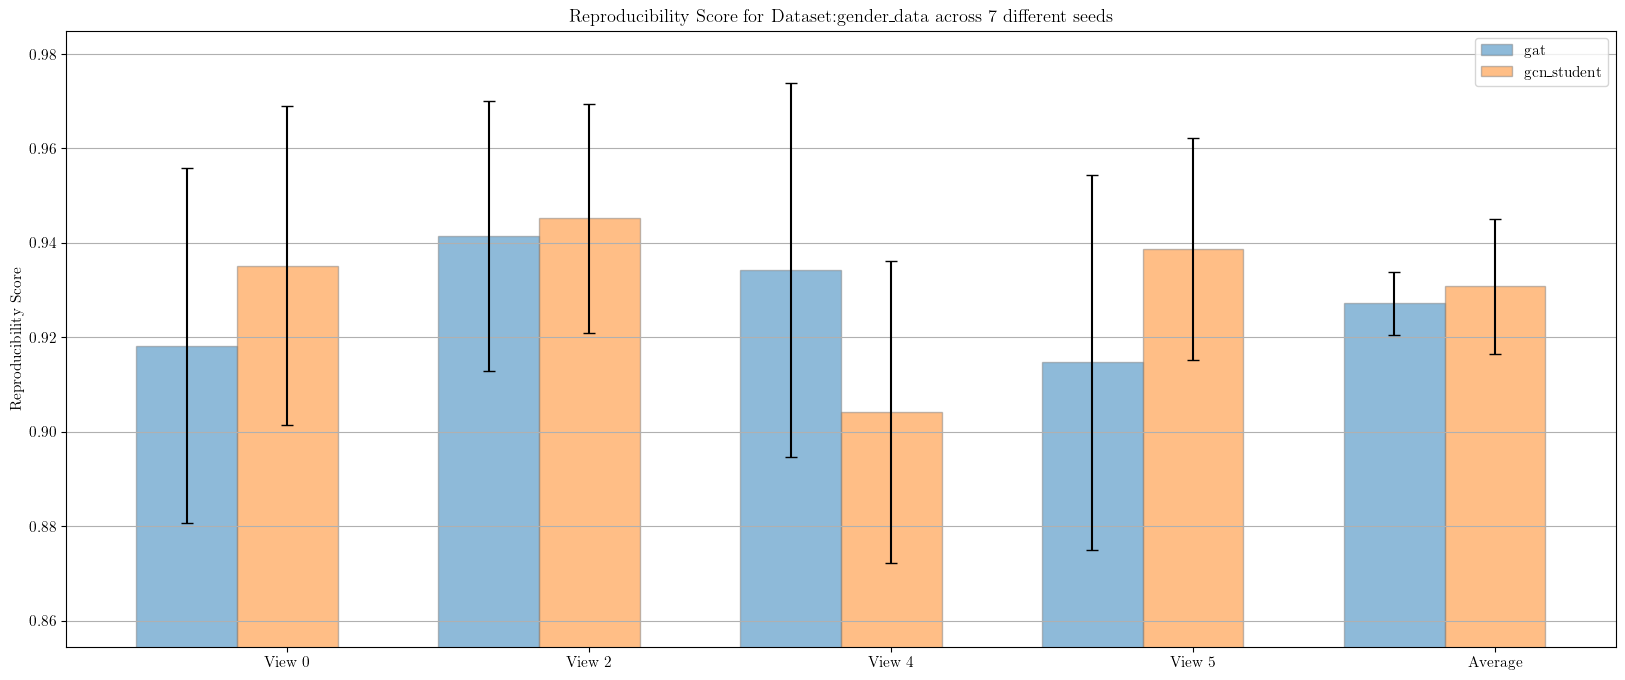

<Figure size 2000x800 with 0 Axes>

In [92]:
import matplotlib.pyplot as plt

plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
params = {
    'text.usetex' : True,
    'font.size' : 11,
    'font.family' :'lmodern'
}
plt.rcParams.update(params)

dataset="gender_data"
views=[0, 2, 4, 5]
models=["gat", "gcn_student"]
model_args = [gat_args, gcn_student_args]
CV=["3Fold", "5Fold", "10Fold"]
runs=[i for i in range(7)]
save_fig=False

plot_bar_chart_reproducibility_mulitple_runs(dataset, views, models, CV, runs, students=[-1,-1,-1,-1,-1,-1], model_args=model_args, save_fig=False)

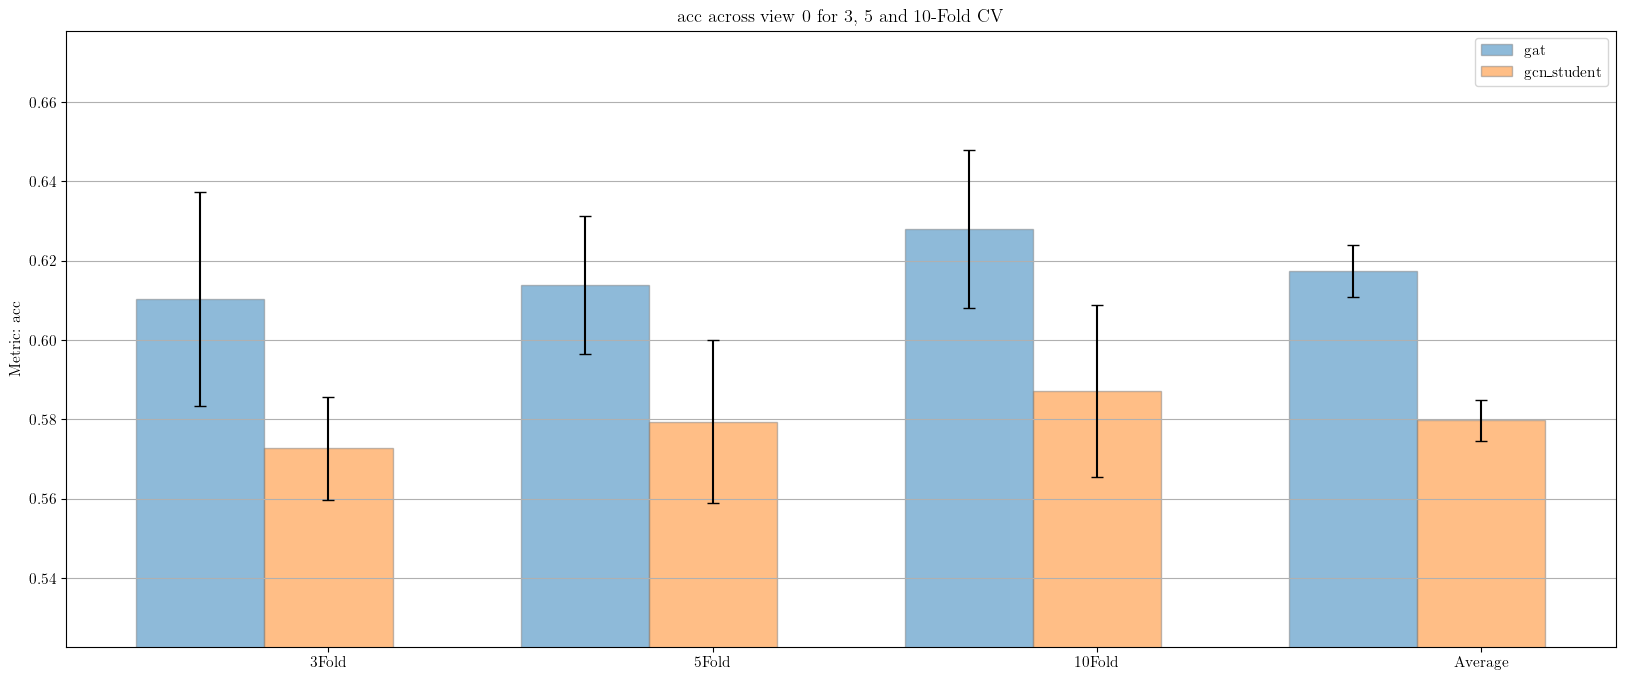

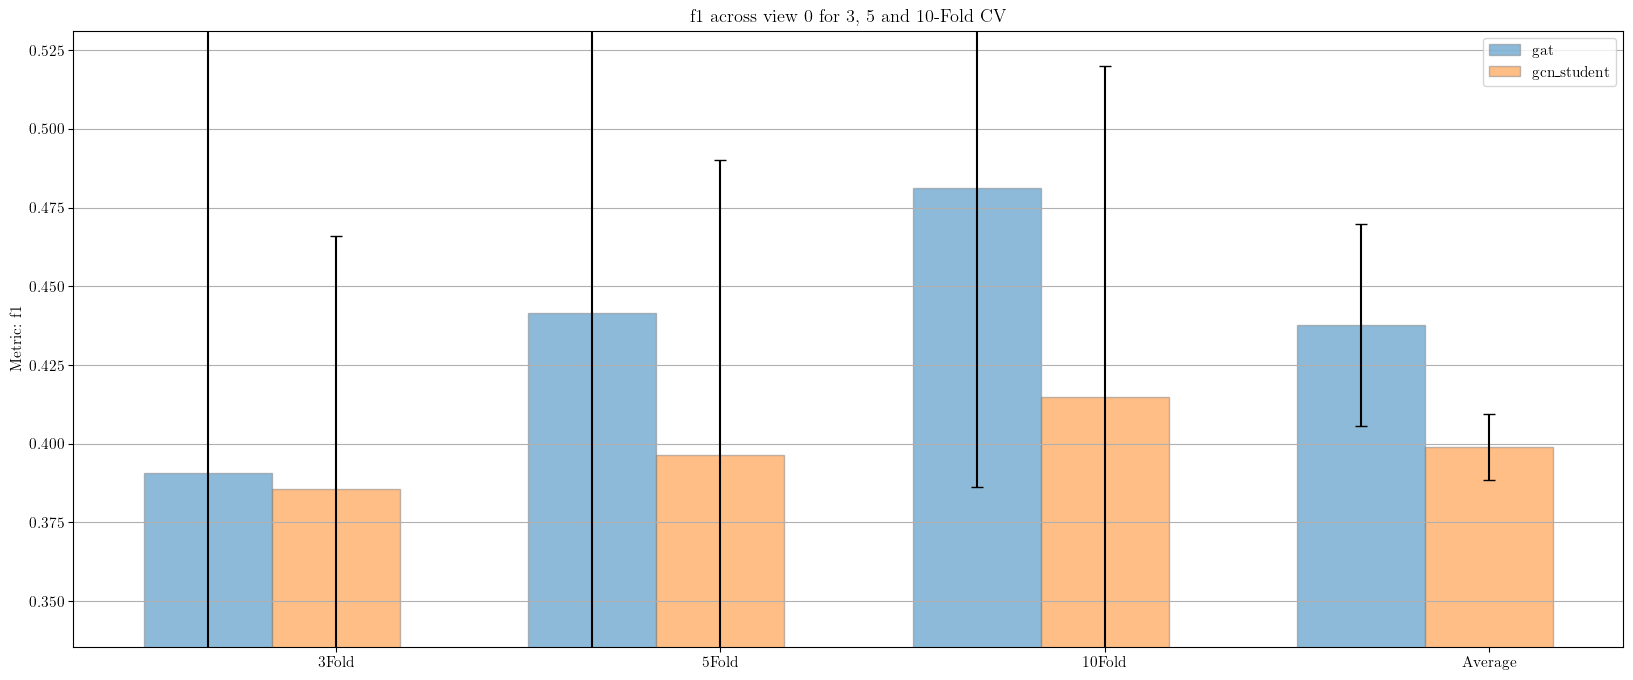

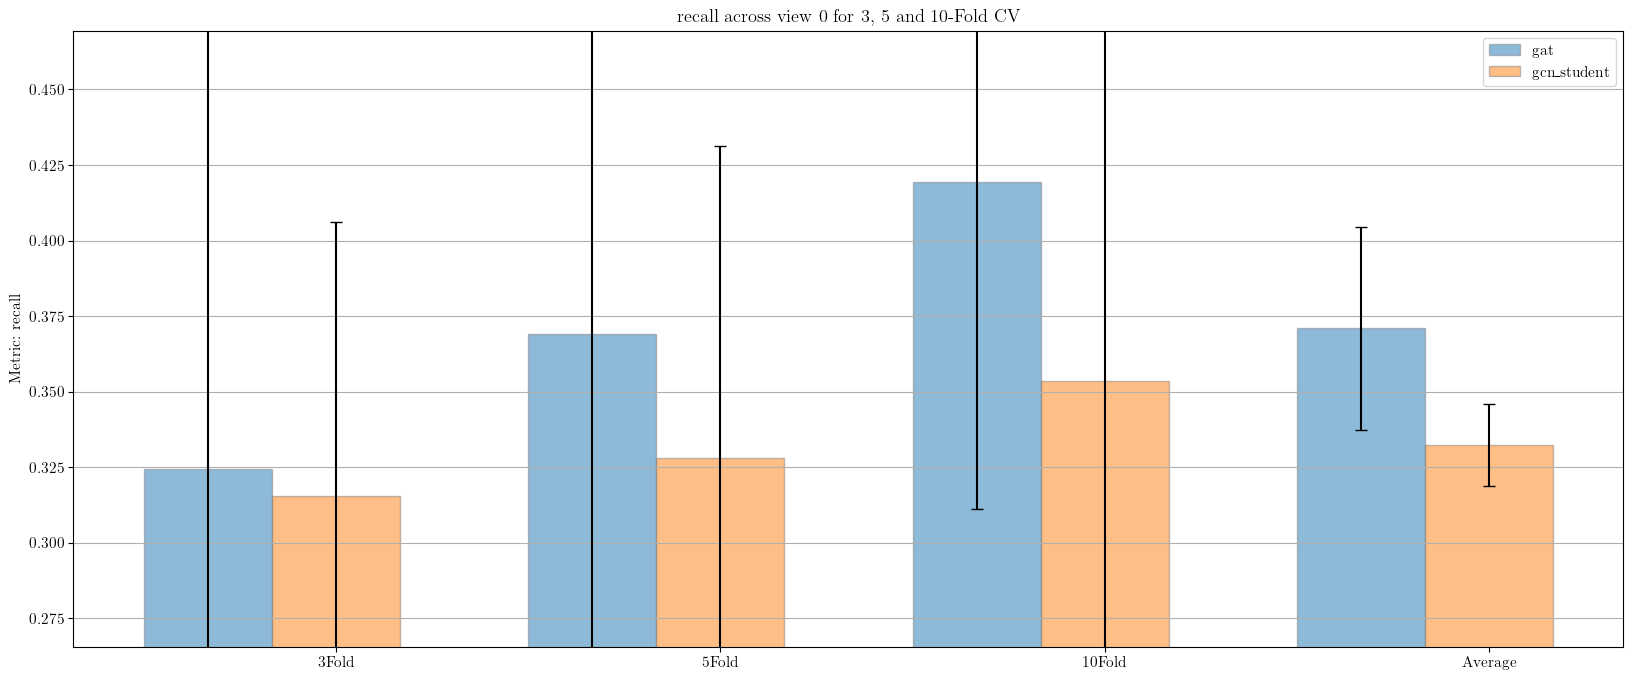

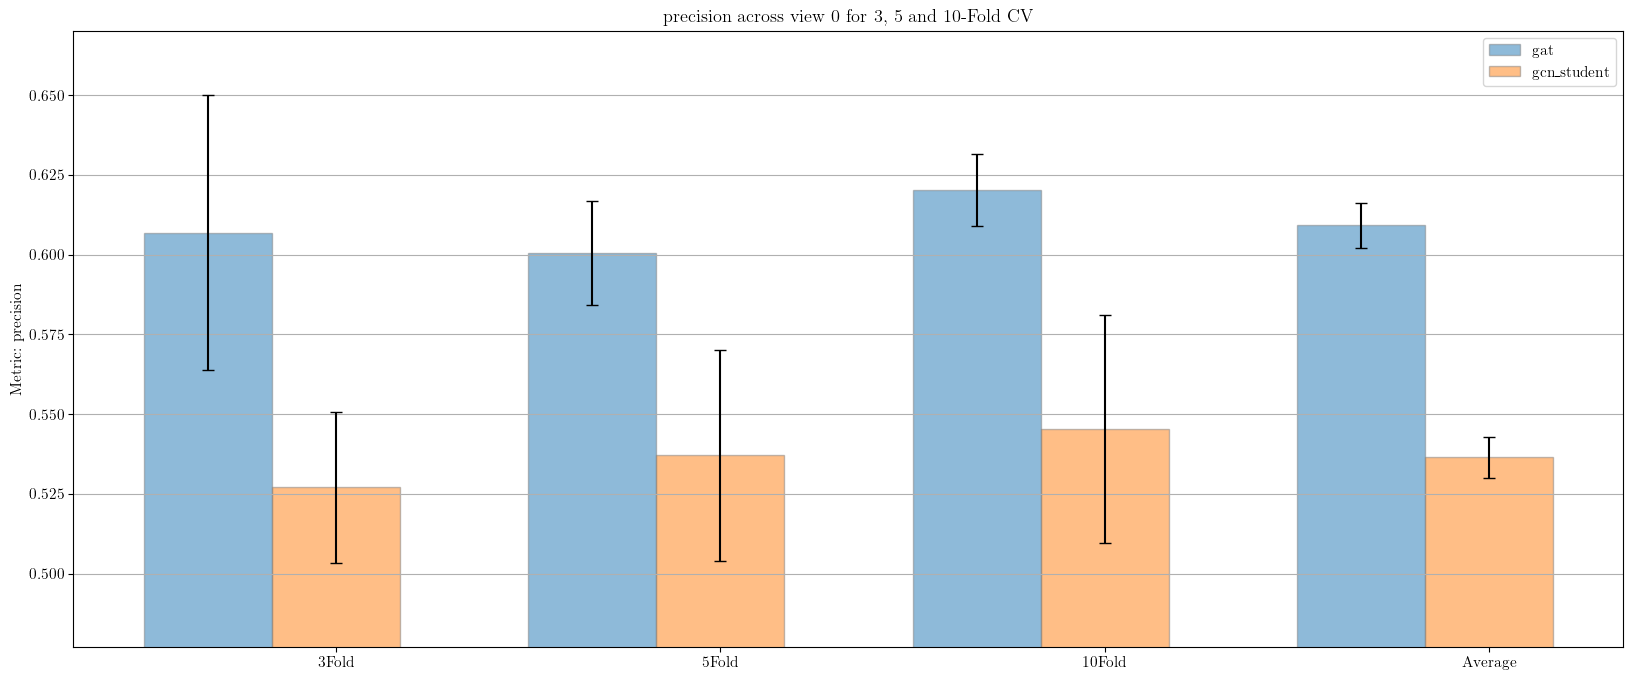

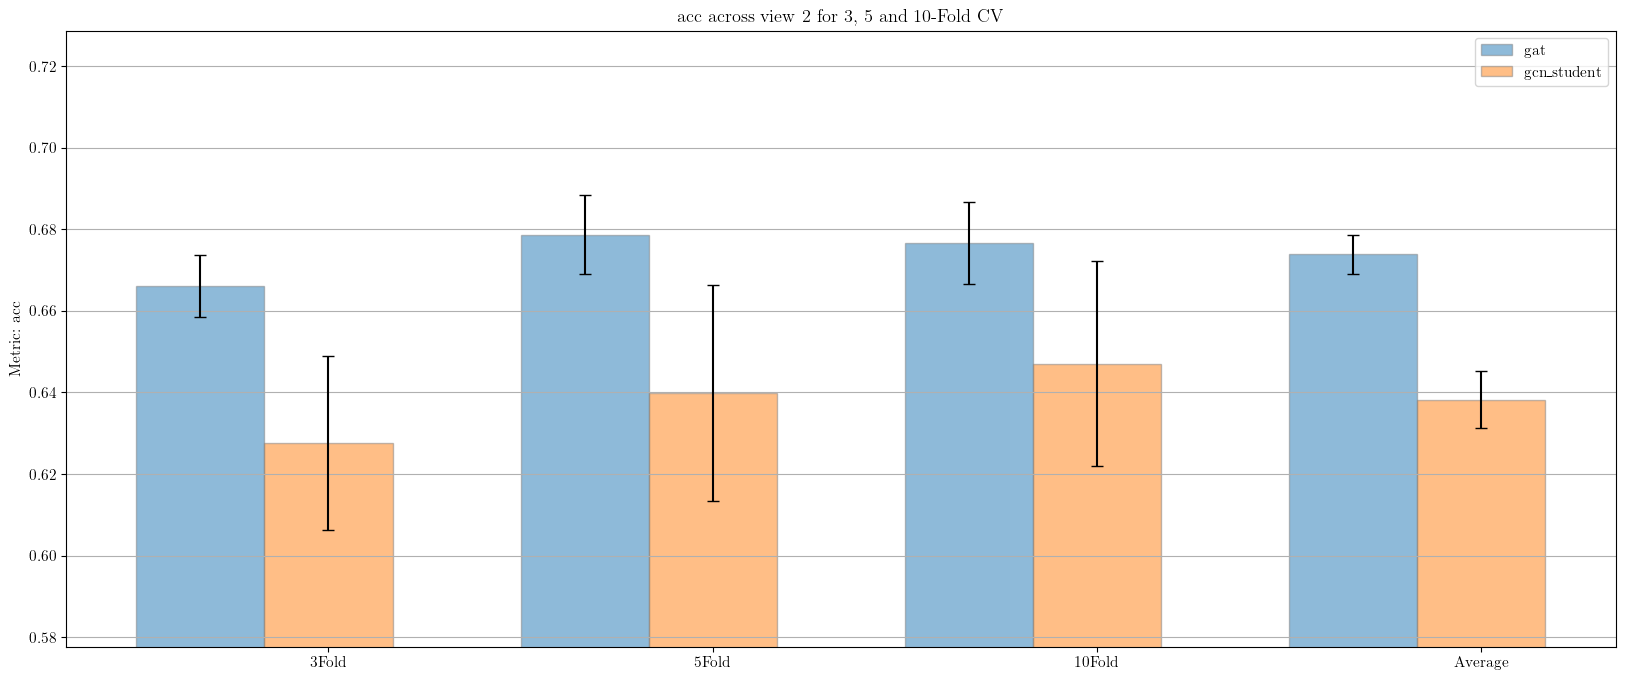

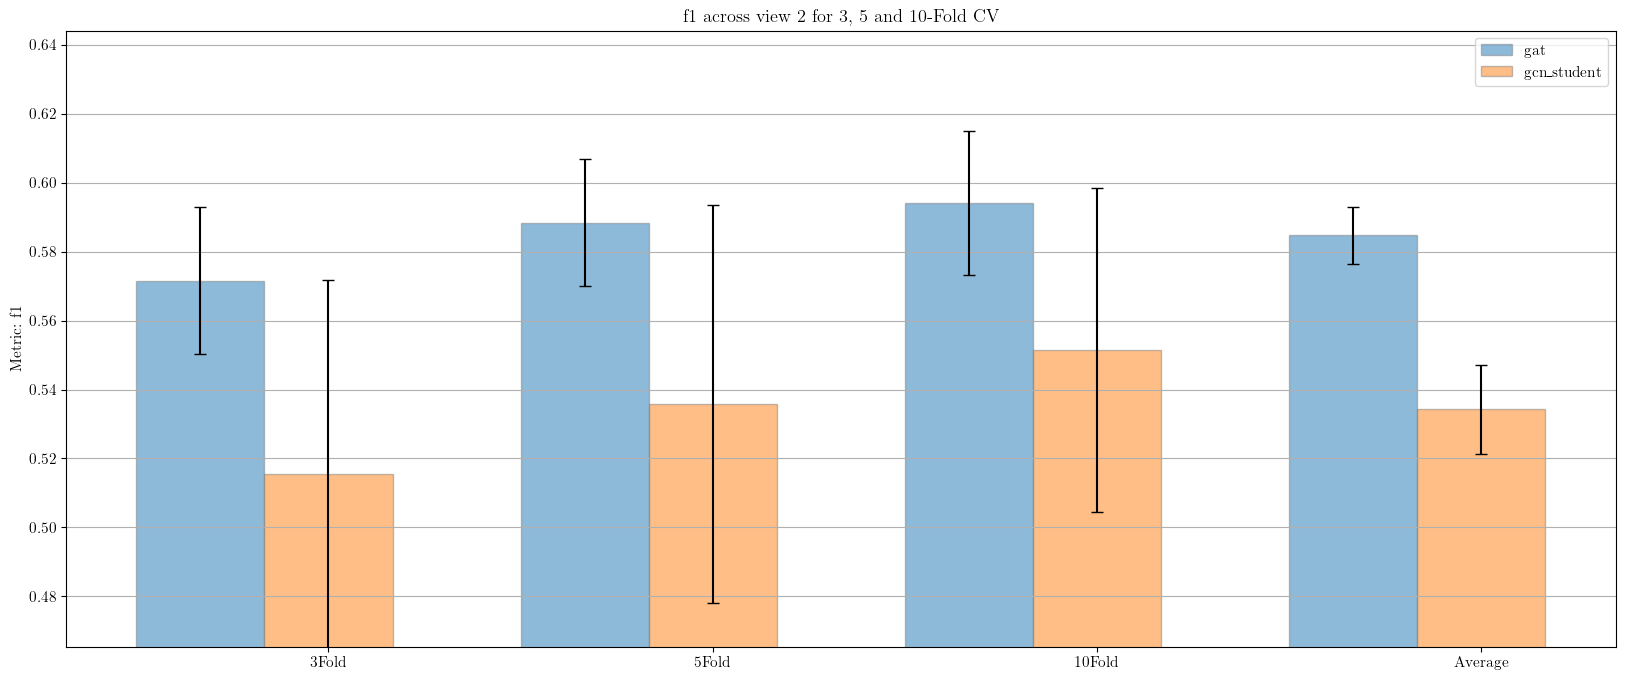

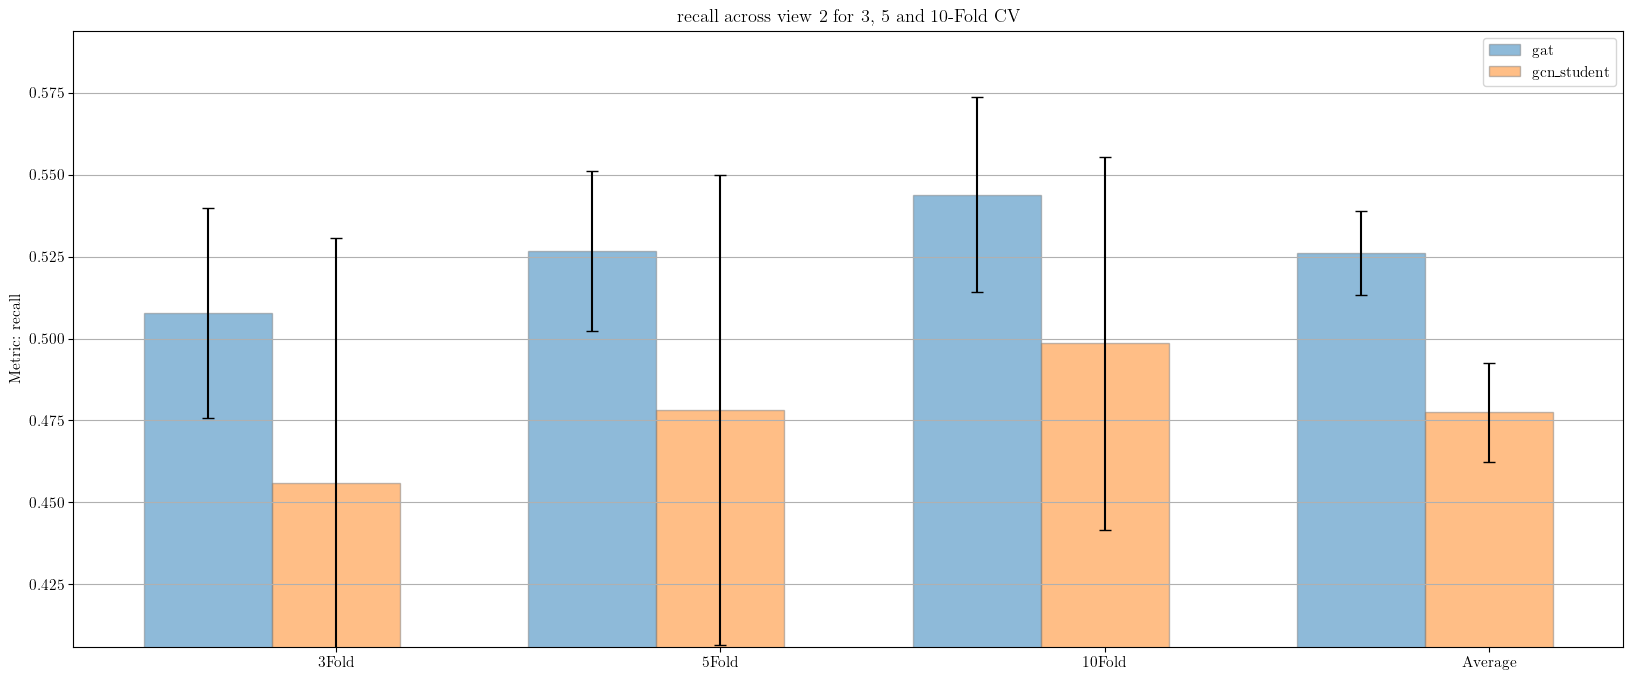

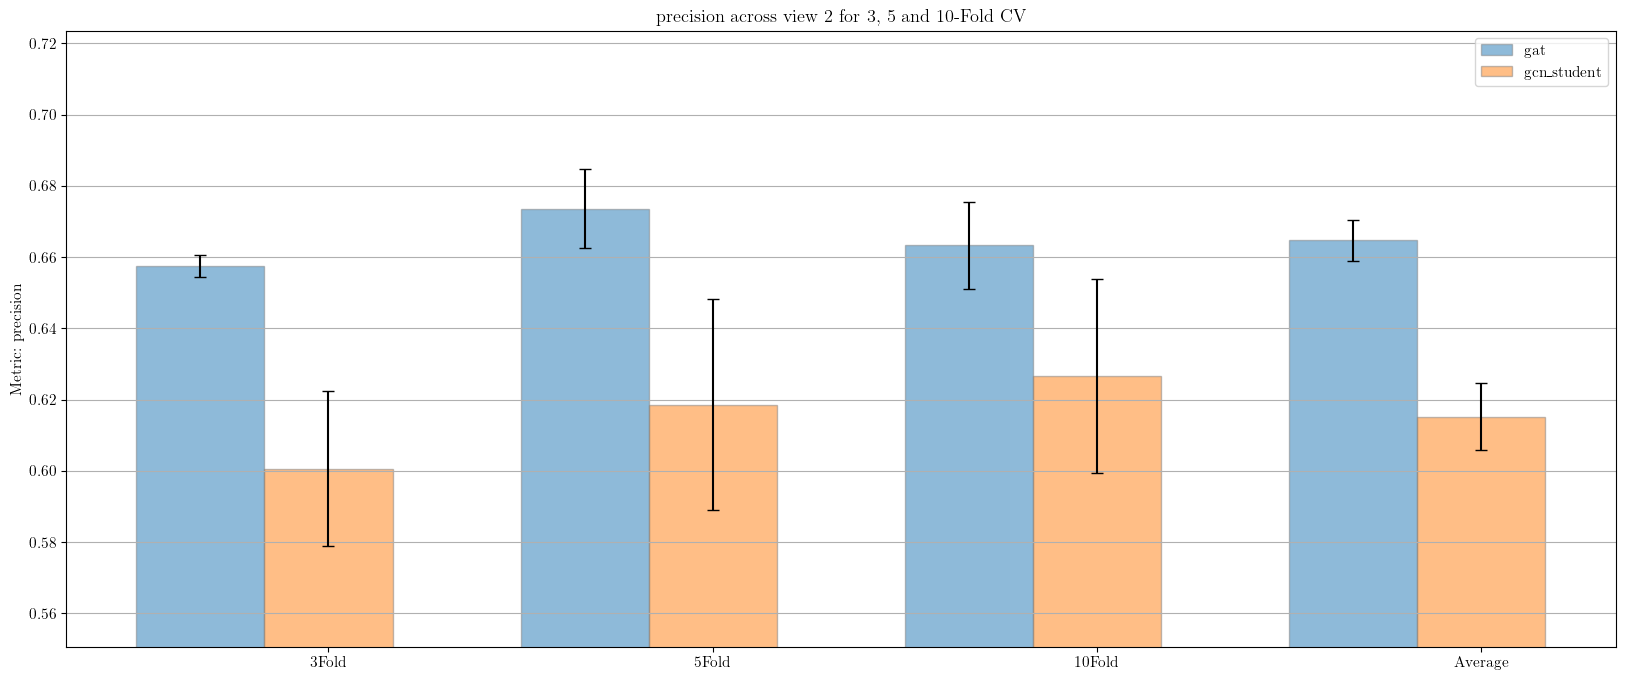

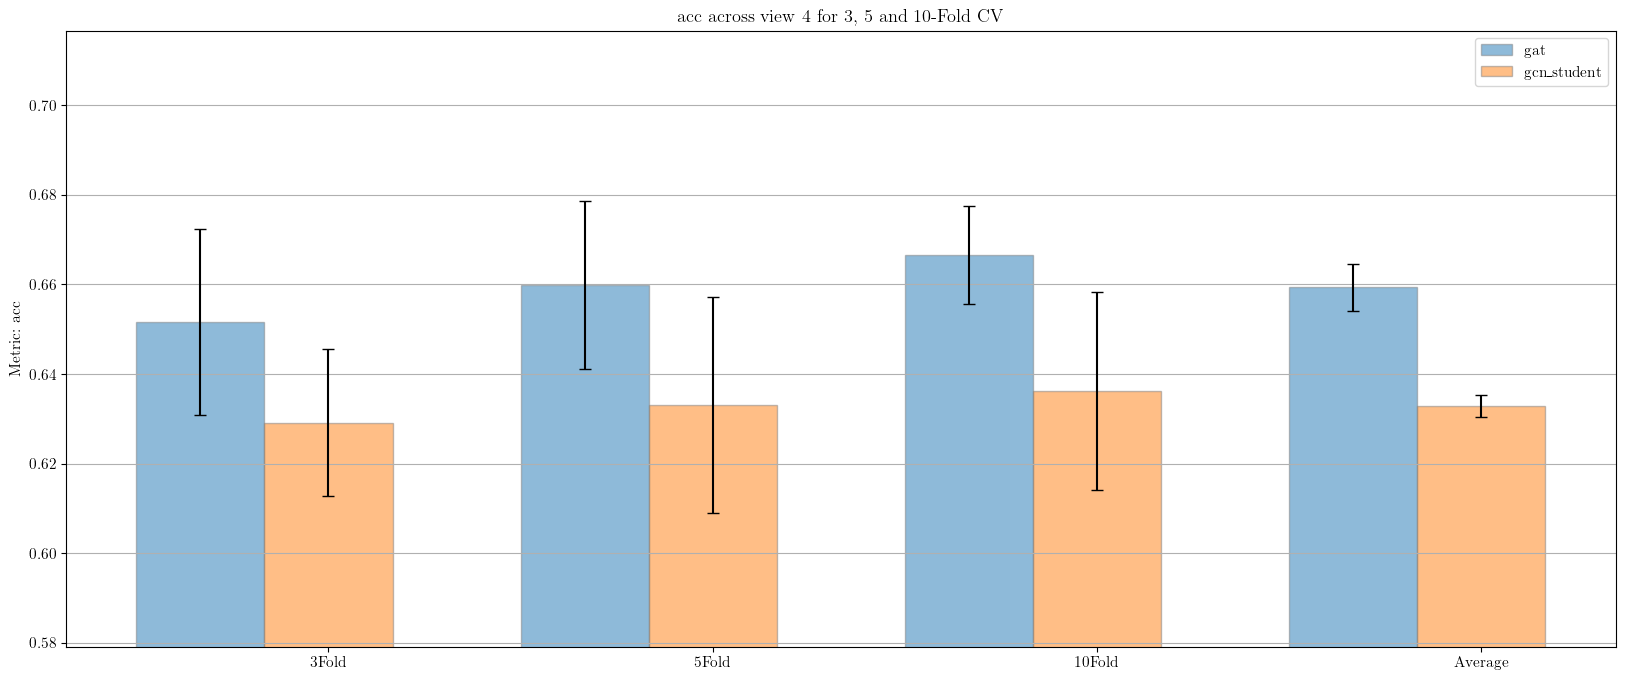

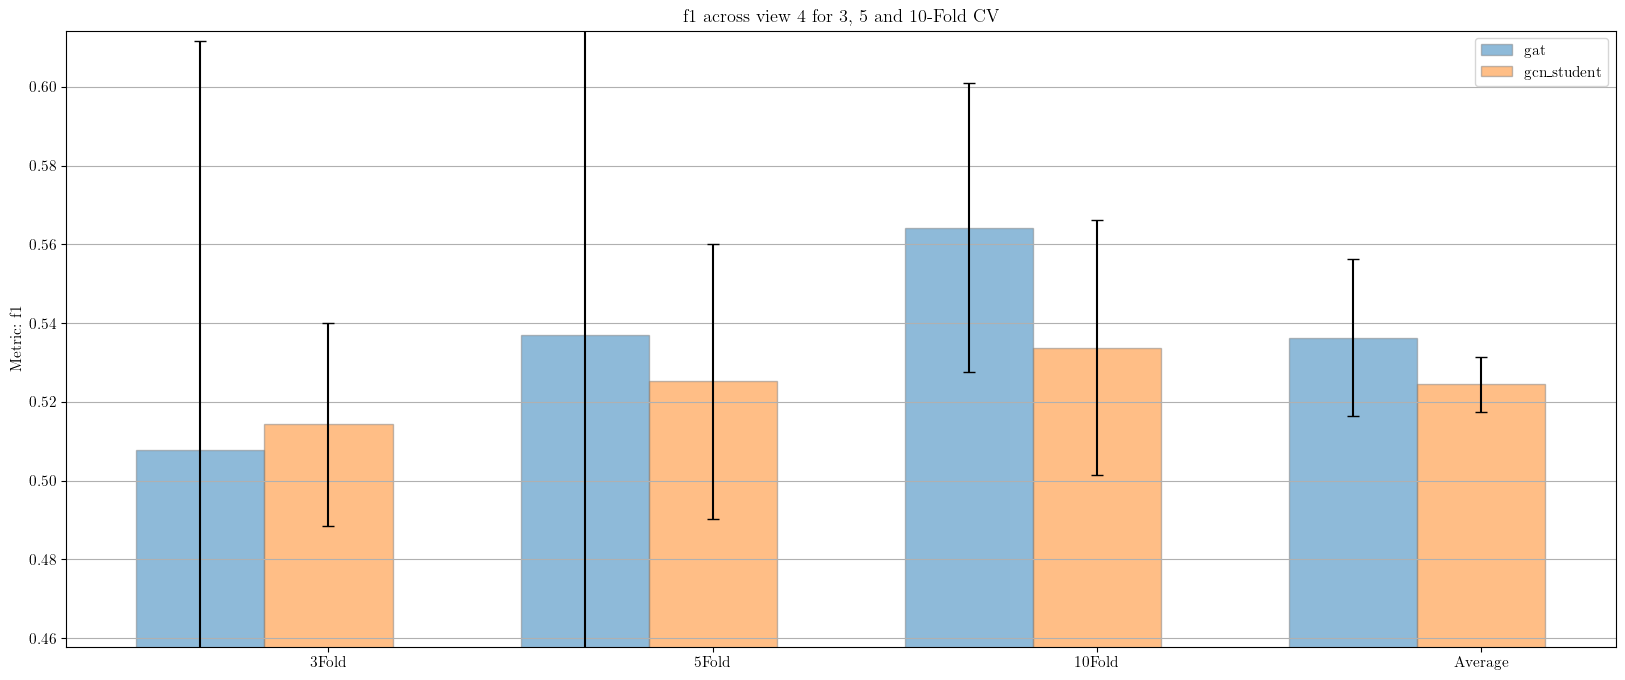

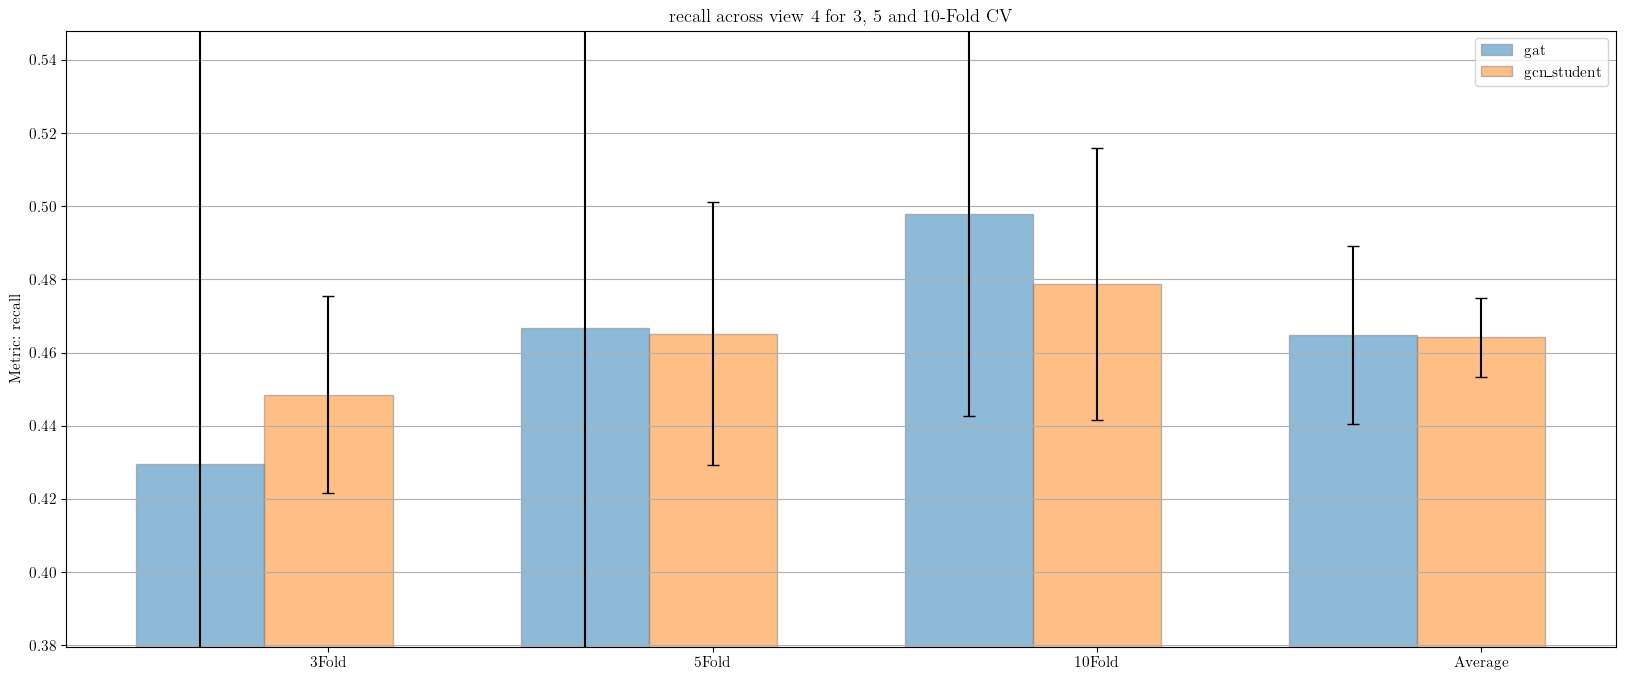

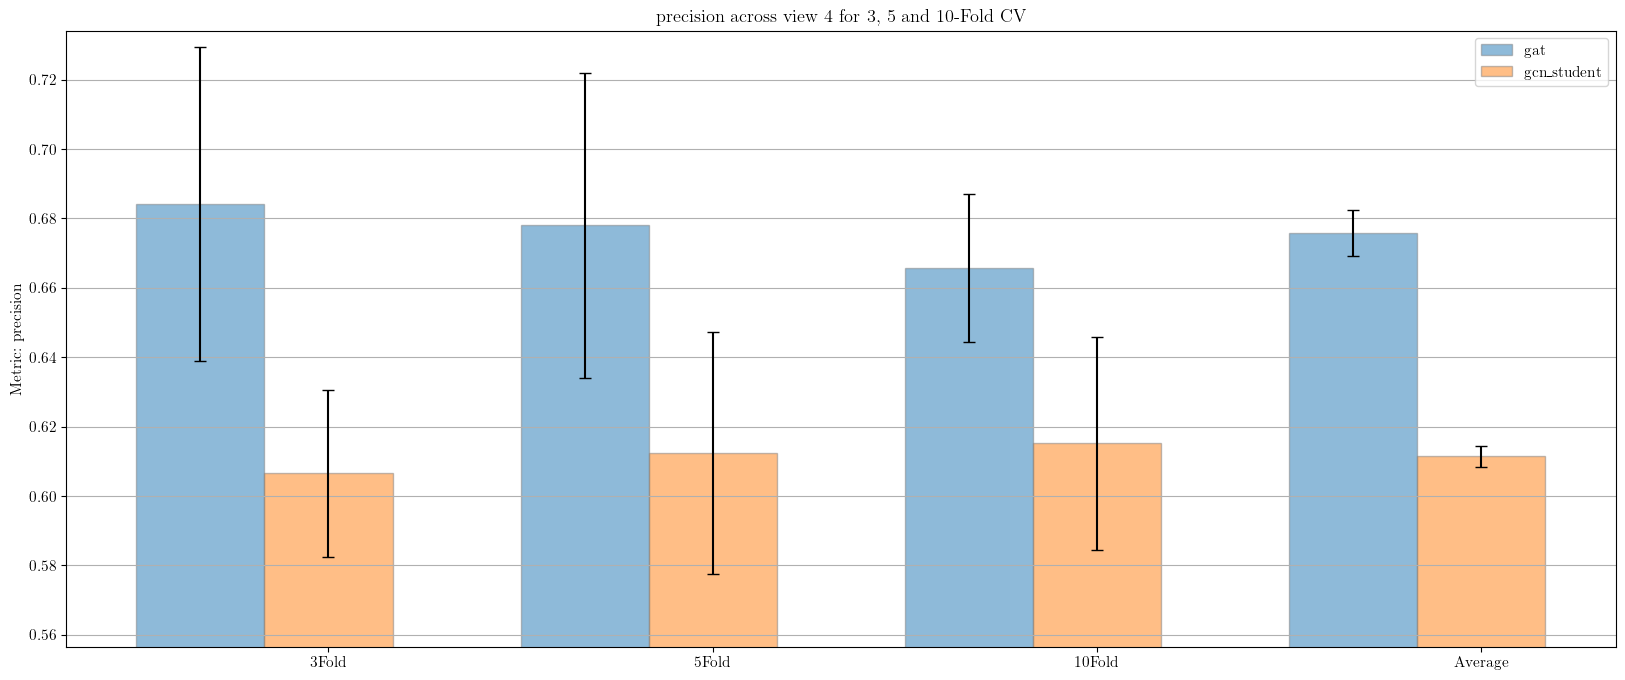

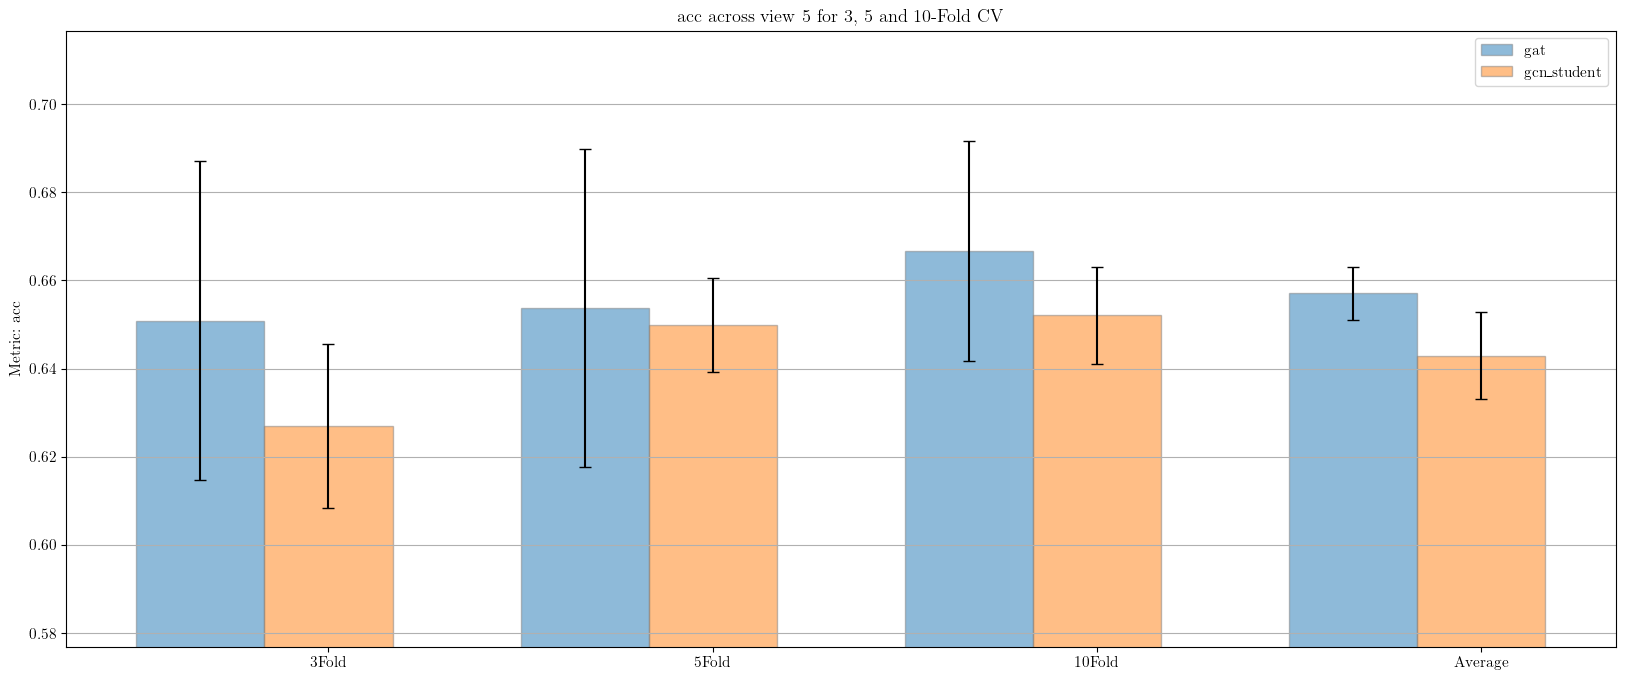

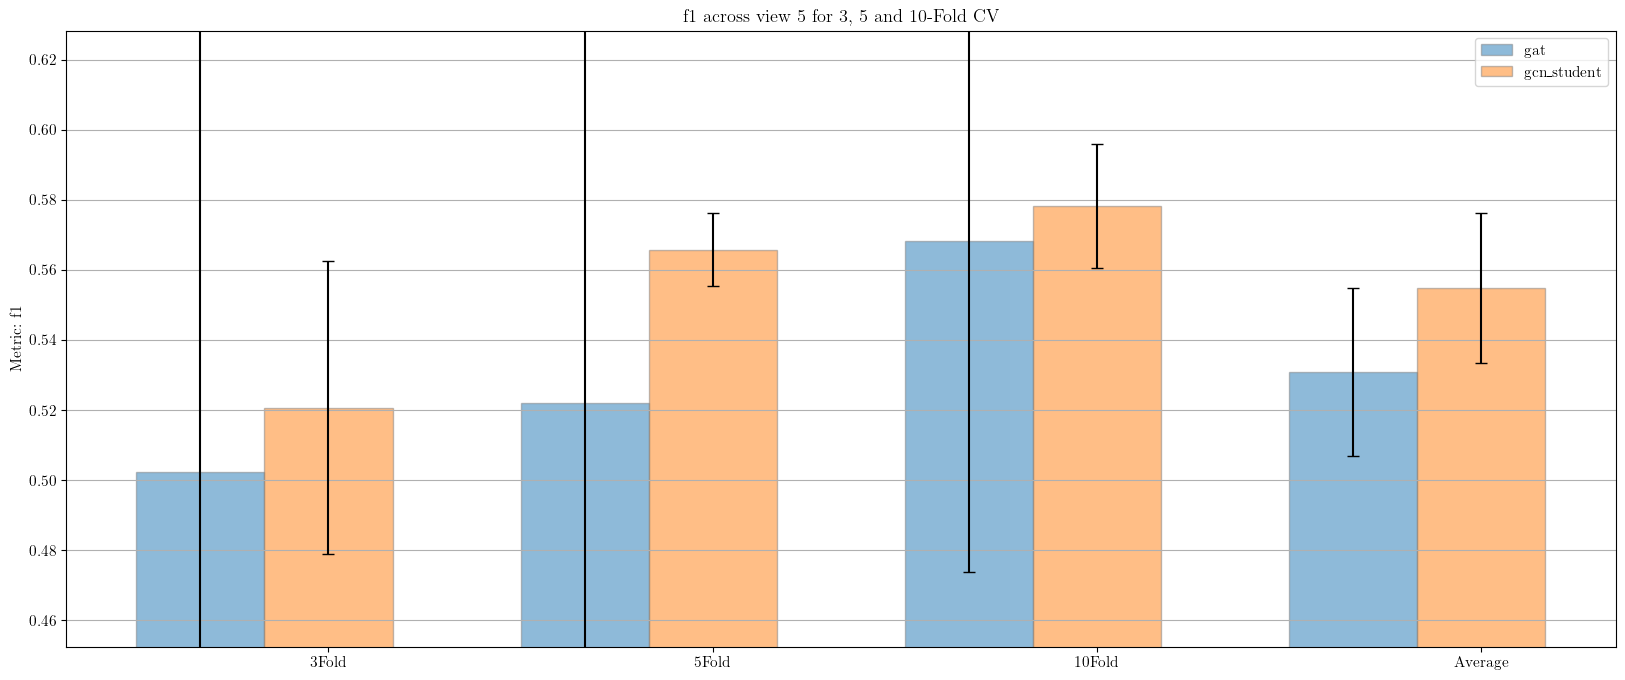

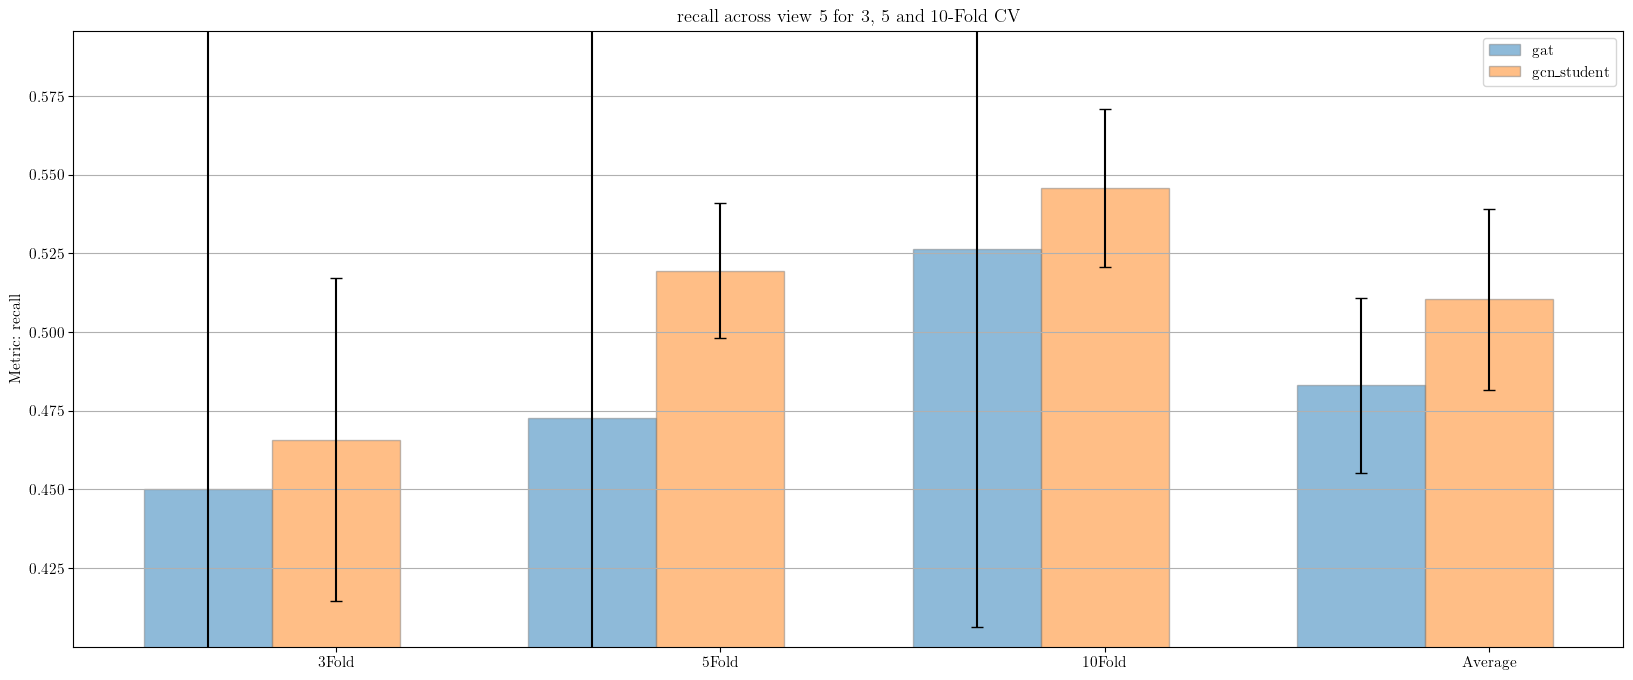

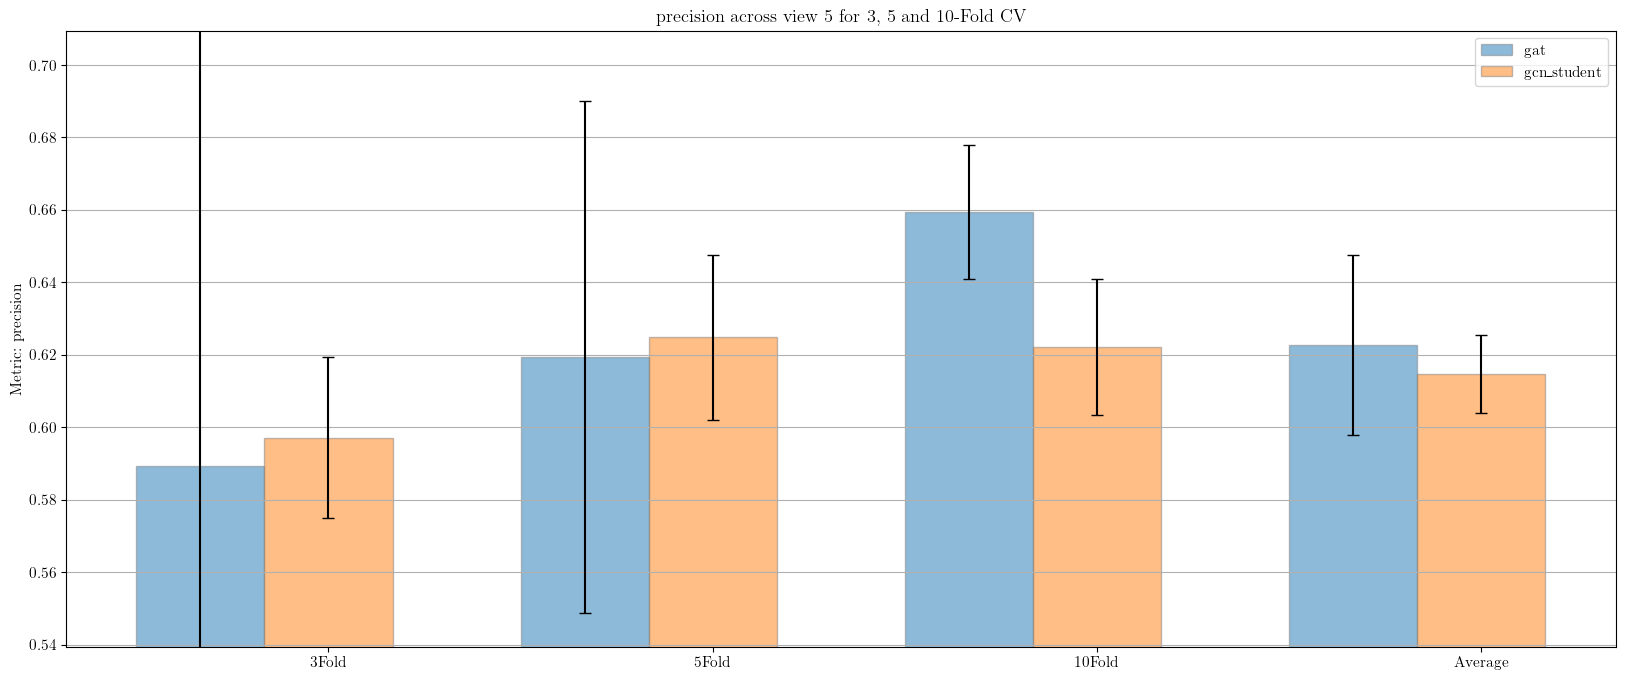

<Figure size 2000x800 with 0 Axes>

In [91]:
model_args = [gat_args, gcn_student_args]

for view in [0,2,4,5]:
    plot_bar_chart_metric_multiple_runs(dataset="gender_data", view=view, models=["gat", "gcn_student"], CV=["3Fold", "5Fold", "10Fold"], runs=[i for i in range(7)], metric="acc", model_args=model_args, dataset_split="val", analysis_type="model_assessment", save_fig=False)
    plot_bar_chart_metric_multiple_runs(dataset="gender_data", view=view, models=["gat", "gcn_student"], CV=["3Fold", "5Fold", "10Fold"], runs=[i for i in range(7)], metric="f1", model_args=model_args,dataset_split="val", analysis_type="model_assessment", save_fig=False)
    plot_bar_chart_metric_multiple_runs(dataset="gender_data", view=view, models=["gat", "gcn_student"], CV=["3Fold", "5Fold", "10Fold"], runs=[i for i in range(7)], metric="recall", model_args=model_args, dataset_split="val", analysis_type="model_assessment", save_fig=False)
    plot_bar_chart_metric_multiple_runs(dataset="gender_data", view=view, models=["gat", "gcn_student"], CV=["3Fold", "5Fold", "10Fold"], runs=[i for i in range(7)], metric="precision", model_args=model_args, dataset_split="val", analysis_type="model_assessment", save_fig=False)